# 1.  Gather and Label Training Images


Before we start training, we need to gather and label images that will be used for training the object detection model. A good starting point for a proof-of-concept model is 200 images. The training images should have random objects in the image along with the desired objects, and should have a variety of backgrounds and lighting conditions.

There are a couple options for gathering images:

    Build a custom dataset by taking your own pictures of the objects and labeling them (this typically results in the best performance)
    Find a pre-made dataset from sources like Roboflow Universe, Kaggle, or Google Images V7

If you want to build your own dataset, there are several tools available for labeling images. One good option is Label Studio, a free and open-source labeling tool that has a simple workflow while providing capabilities for more advanced features

If you used Label Studio to label and export the images, they'll be exported in a project.zip file that contains the following:

    An images folder containing the images
    A labels folder containing the labels in YOLO annotation format
    A classes.txt labelmap file that contains all the classes
    A notes.json file that contains info specific to Label Studio (this file can be ignored)

If you obtained your dataset from another source (like Roboflow Universe) or used another tool to label your dataset, make sure the files are organized in the same folder structure.


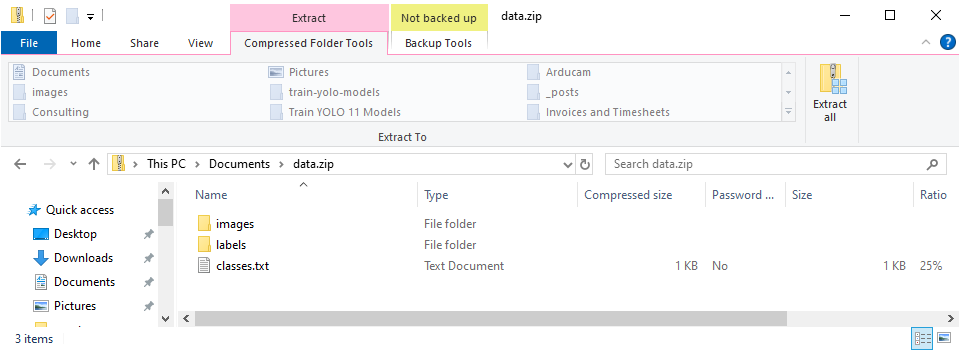

# 2. Upload Image Dataset and Prepare Training Data

Next, we'll upload our dataset and prepare it for training with YOLO. We'll split the dataset into train and validation folders, and we'll automatically generate the configuration file for training the model.

Option 1. Upload through Google Colab

Upload the data.zip file to the Google Colab instance by clicking the "Files" icon on the left hand side of the browser, and then the "Upload to session storage" icon. Select the zip folder to upload it.

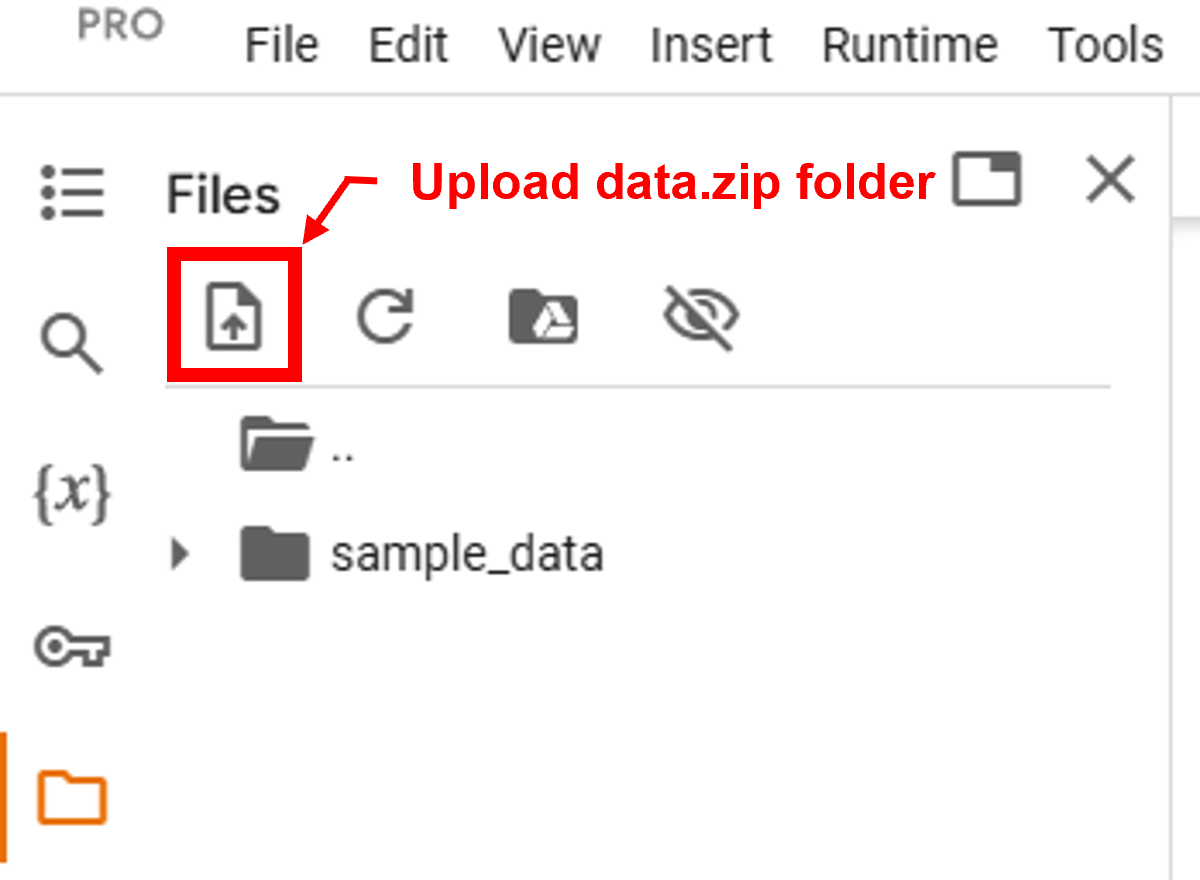



Option 2. Copy from Google Drive

You can also upload your images to your personal Google Drive, mount the drive on this Colab session, and copy them over to the Colab filesystem. This option works well if you want to upload the images beforehand so you don't have to wait for them to upload each time you restart this Colab. If you have more than 50MB worth of images, I recommend using this option.

First, upload the data.zip file to your Google Drive, and make note of the folder you uploaded them to. Replace MyDrive/path/to/data.zip with the path to your zip file. (For example, I uploaded the zip file to folder called "candy-dataset1", so I would use MyDrive/candy-dataset1/data.zip for the path). Then, run the following block of code to mount your Google Drive to this Colab session and copy the folder to this filesystem.


2.2 Split images into train and validation folders

At this point, whether you used Option 1,or 2, you should be able to click the folder icon on the left and see your data.zip file in the list of files. Next, we'll unzip data.zip and create some folders to hold the images. Run the following code block to unzip the data.

In [ ]:
# Unzip images to a custom data folder
!unzip -q /content/data.zip -d /content/custom_data

unzip:  cannot find or open /content/data.zip, /content/data.zip.zip or /content/data.zip.ZIP.




Ultralytics requires a particular folder structure to store training data for models. Ultralytics requires a particular folder structure to store training data for models. The root folder is named “data”. Inside, there are two main folders:

    Train: These are the actual images used to train the model. In one epoch of training, every image in the train set is passed into the neural network. The training algorithm adjusts the network weights to fit the data in the images.

    Validation: These images are used to check the model's performance at the end of each training epoch.

In each of these folders is a “images” folder and a “labels” folder, which hold the image files and annotation files respectively.

I wrote a Python script that will automatically create the required folder structure and randomly move 90% of dataset to the "train" folder and 10% to the "validation" folder. Run the following code block to download and execute the scrpt.


In [ ]:
%%writefile /content/train_val_split.py

from pathlib import Path
import random
import os
import sys
import shutil
import argparse


# Define and parse user input arguments
parser = argparse.ArgumentParser()
parser.add_argument('--datapath', help='Path to data folder containing image and annotation files',
                    required=True)
parser.add_argument('--train_pct', help='Ratio of images to go to train folder; \
                    the rest go to validation folder (example: ".8")',
                    default=.8)

args = parser.parse_args()

data_path = args.datapath
train_percent = float(args.train_pct)

# Check for valid entries
if not os.path.isdir(data_path):
   print(f'Error: Directory specified by --datapath not found at "{data_path}".')
   sys.exit(0)
if train_percent < .01 or train_percent > 0.99:
   print('Error: Invalid entry for --train_pct. Please enter a number between 0.01 and 0.99.')
   sys.exit(0)
val_percent = 1 - train_percent

# Define path to input dataset
input_image_path = os.path.join(data_path,'images')
input_label_path = os.path.join(data_path,'labels')

# Define paths to image and annotation folders
cwd = os.getcwd()
train_img_path = os.path.join(cwd,'data/train/images')
train_txt_path = os.path.join(cwd,'data/train/labels')
val_img_path = os.path.join(cwd,'data/validation/images')
val_txt_path = os.path.join(cwd,'data/validation/labels')

# Create folders if they don't already exist
for dir_path in [train_img_path, train_txt_path, val_img_path, val_txt_path]:
   if not os.path.exists(dir_path):
      os.makedirs(dir_path)
      print(f'Created folder at: {dir_path}')

# Get list of all images and annotation files
img_file_list = [path for path in Path(input_image_path).rglob('*')]

print(f'\nFound {len(img_file_list)} image files.')

# Determine number of files to move to each folder
file_num = len(img_file_list)
train_num = int(file_num*train_percent)
val_num = file_num - train_num
print(f'Splitting into {train_num} training images and {val_num} validation images.')

# Select files randomly and copy them to train or val folders
for i, set_num in enumerate([train_num, val_num]):
  for ii in range(set_num):
    # Randomly pick an image from the remaining list
    img_path = random.choice(img_file_list)

    # Get the corresponding file names
    img_fn = img_path.name
    base_fn = img_path.stem
    txt_fn = base_fn + '.txt'
    txt_path = os.path.join(input_label_path, txt_fn)

    # Determine the destination folder (train or validation)
    if i == 0: # First iteration is for the training set
      new_img_path, new_txt_path = train_img_path, train_txt_path
    elif i == 1: # Second iteration is for the validation set
      new_img_path, new_txt_path = val_img_path, val_txt_path

    # Copy the image file
    shutil.copy(img_path, os.path.join(new_img_path, img_fn))

    # Copy the label file if it exists
    if os.path.exists(txt_path):
      shutil.copy(txt_path, os.path.join(new_txt_path, txt_fn))

    # Remove the moved image from the list to prevent it from being chosen again
    img_file_list.remove(img_path)

print('\n✅ File splitting process completed successfully.')
print("-" * 30)


# --- 3. RUN THE SCRIPT ---
# This executes the script we just created with the specified arguments.
!python /content/train_val_split.py --datapath="/content/custom_data" --train_pct=0.9


usage: colab_kernel_launcher.py [-h] --datapath DATAPATH
                                [--train_pct TRAIN_PCT]
colab_kernel_launcher.py: error: the following arguments are required: --datapath
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/lib/python3.12/argparse.py", line 1943, in _parse_known_args2
    namespace, args = self._parse_known_args(args, namespace, intermixed)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/argparse.py", line 2230, in _parse_known_args
    raise ArgumentError(None, _('the following arguments are required: %s') %
argparse.ArgumentError: the following arguments are required: --datapath

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipython-input-4160897882.py", line 20, in <cell line: 0>
    args = parser.parse_args()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/argparse.py", line 1904, in parse_args
    args, argv = self.parse_known_args(args, namespac

TypeError: object of type 'NoneType' has no len()

In [2]:
!pip install ultralytics

# Configure Training


There's one last step before we can run training: we need to create the Ultralytics training configuration YAML file. This file specifies the location of your train and validation data, and it also defines the model's classes. An example configuration file model is available here.

Run the code block below to automatically generate a data.yaml configuration file. Make sure you have a labelmap file located at custom_data/classes.txt. If you used Label Studio or one of my pre-made datasets, it should already be present. If you assembled the dataset another way, you may have to manually create the classes.txt file (see here for an example of how it's formatted).


In [3]:
# Python function to automatically create data.yaml config file
# 1. Reads "classes.txt" file to get list of class names
# 2. Creates data dictionary with correct paths to folders, number of classes, and names of classes
# 3. Writes data in YAML format to data.yaml

import yaml
import os

def create_data_yaml(path_to_classes_txt, path_to_data_yaml):

  # Read class.txt to get class names
  if not os.path.exists(path_to_classes_txt):
    print(f'classes.txt file not found! Please create a classes.txt labelmap and move it to {path_to_classes_txt}')
    return
  with open(path_to_classes_txt, 'r') as f:
    classes = []
    for line in f.readlines():
      if len(line.strip()) == 0: continue
      classes.append(line.strip())
  number_of_classes = len(classes)

  # Create data dictionary
  data = {
      'path': '/content/data',
      'train': 'train/images',
      'val': 'validation/images',
      'nc': number_of_classes,
      'names': classes
  }

  # Write data to YAML file
  with open(path_to_data_yaml, 'w') as f:
    yaml.dump(data, f, sort_keys=False)
  print(f'Created config file at {path_to_data_yaml}')

  return

# Define path to classes.txt and run function
path_to_classes_txt = '/content/custom_data/classes.txt'
path_to_data_yaml = '/content/data.yaml'

create_data_yaml(path_to_classes_txt, path_to_data_yaml)

print('\nFile contents:\n')
!cat /content/data.yaml

classes.txt file not found! Please create a classes.txt labelmap and move it to /content/custom_data/classes.txt

File contents:

cat: /content/data.yaml: No such file or directory


# Train Model

## 5.1 Training Parameters
Now that the data is organized and the config file is created, we're ready to start training! First, there are a few important parameters to decide on. Visit my article on [Training YOLO Models Locally](https://www.ejtech.io/learn/train-yolo-models) to learn more about these parameters and how to choose them.

**Model architecture & size (`model`):**

There are several YOLO11 models sizes available to train, including `yolo11n.pt`, `yolo11s.pt`, `yolo11m.pt`, `yolo11l.pt`, and `yolo11xl.pt`. Larger models run slower but have higher accuracy, while smaller models run faster but have lower accuracy. I made a brief YouTube video that compares performance of different YOLO models on a Raspberry Pi 5 and a laptop with a RTX 4050 GPU, [check it out here to get a sense of their speed accuracy](https://youtu.be/_WKS4E9SmkA). If you aren't sure which model size to use, `yolo11s.pt` is a good starting point.

You can also train YOLOv8 or YOLOv5 models by substituting `yolo11` for `yolov8` or `yolov5`.


**Number of epochs (`epochs`)**

In machine learning, one “epoch” is one single pass through the full training dataset. Setting the number of epochs dictates how long the model will train for. The best amount of epochs to use depends on the size of the dataset and the model architecture. If your dataset has less than 200 images, a good starting point is 60 epochs. If your dataset has more than 200 images, a good starting point is 40 epochs.


**Resolution (`imgsz`)**

Resolution has a large impact on the speed and accuracy of the model: a lower resolution model will have higher speed but less accuracy. YOLO models are typically trained and inferenced at a 640x640 resolution. However, if you want your model to run faster or know you will be working with low-resolution images, try using a lower resolution like 480x480.

## 5.2 Run Training!

Run the following code block to begin training. If you want to use a different model, number of epochs, or resolution, change model, epochs, or imgsz.

In [6]:
!yolo detect train data=/content/data.yaml model=yolo11s.pt epochs=60 imgsz=640

Traceback (most recent call last):
  File "/usr/local/bin/yolo", line 5, in <module>
    from ultralytics.cfg import entrypoint
  File "/usr/local/lib/python3.12/dist-packages/ultralytics/__init__.py", line 11, in <module>
    from ultralytics.models import NAS, RTDETR, SAM, YOLO, YOLOE, FastSAM, YOLOWorld
  File "/usr/local/lib/python3.12/dist-packages/ultralytics/models/__init__.py", line 3, in <module>
    from .fastsam import FastSAM
  File "/usr/local/lib/python3.12/dist-packages/ultralytics/models/fastsam/__init__.py", line 3, in <module>
    from .model import FastSAM
  File "/usr/local/lib/python3.12/dist-packages/ultralytics/models/fastsam/model.py", line 6, in <module>
    from ultralytics.engine.model import Model
  File "/usr/local/lib/python3.12/dist-packages/ultralytics/engine/model.py", line 8, in <module>
    import torch
  File "/usr/local/lib/python3.12/dist-packages/torch/__init__.py", line 2150, in <module>
    from torch import _VF as _VF, functional as functional 

The training algorithm will parse the images in the training and validation directories and then start training the model. At the end of each training epoch, the program runs the model on the validation dataset and reports the resulting mAP, precision, and recall. As training continues, the mAP should generally increase with each epoch. Training will end once it goes through the number of epochs specified by `epochs`.

> **NOTE:** Make sure to allow training to run to completion, because an optimizer runs at the end of training that strips out unneeded layers from the model.

The best trained model weights will be saved in `content/runs/detect/train/weights/best.pt`. Additional information about training is saved in the `content/runs/detect/train` folder, including a `results.png` file that shows how loss, precision, recall, and mAP progressed over each epoch.

#6.&nbsp;Test Model

The model has been trained; now it's time to test it! The commands below run the model on the images in the validation folder and then display the results for the first 10 images. This is a good way to confirm your model is working as expected. Click Play on the blocks below to see how your model performs.

In [7]:
!yolo detect predict model=runs/detect/train/weights/best.pt source=data/validation/images save=True

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Traceback (most recent call last):
  File "/usr/local/bin/yolo", line 8, in <module>
    sys.exit(entrypoint())
             ^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ultralytics/cfg/__init__.py", line 956, in entrypoint
    model = YOLO(model, task=task)
            ^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ultralytics/models/yolo/model.py", line 81, in __init__
    super().__init__(model=model, task=task, verbose=verbose)
  File "/usr/local/lib/python3.12/dist-packages/ultralytics/engine/model.py", line 151, in __init__
    self._load(model, task=task)
  File "/usr/local/lib/python3.12/dist-packages/ultralytics/engine/model.py", li

In [8]:
import glob
from IPython.display import Image, display
for image_path in glob.glob(f'/content/runs/detect/predict/*.jpg')[:10]:
  display(Image(filename=image_path, height=400))
  print('\n')




The model should draw a box around each object of interest in each image. If it isn't doing a good job of detecting objects, here are a few tips:

    Double-check your dataset to make sure there are no labeling errors or conflicting examples.
    Increase the number of epochs used for training.
    Use a larger model size (e.g. yolo11l.pt).
    Add more images to the training dataset. See my dataset video for tips on how to capture good training images and improve accuracy.

You can also run the model on video files or other images images by uploading them to this notebook and using the above !yolo detect predict command, where source points to the location of the video file, image, or folder of images. The results will be saved in runs/detect/predict.

Drawing boxes on images is great, but it isn't very useful in itself. It's also not very helpful to just run this models inside a Colab notebook: it's easier if we can just run it on a local computer. Continue to the next section to see how to download your newly trained model and run it on a local device.


# 7. Deploy Model




Now that your custom model has been trained, it's ready to be downloaded and deployed in an application! YOLO models can run on a wide variety of hardware, including PCs, embedded systems, and phones. Ultralytics makes it easy to convert the YOLO models to various formats (tflite, onnx, etc.) and deploy them in a variety of environments.

This section shows how to download the model and provides links to instructions for deploying it on your PC and edge devices like the Raspberry Pi.


## 7.1 Download YOLO Model

First, zip and download the trained model by running the code blocks below.

The code creates a folder named `my_model`, moves the model weights into it, and renames them from `best.pt` to `my_model.pt`. It also adds the training results in case you want to reference them later. It then zips the folder as `my_model.zip`.

In [10]:
# Create "my_model" folder to store model weights and train results
!mkdir /content/my_model
!cp /content/runs/detect/train/weights/best.pt /content/my_model/my_model.pt
!cp -r /content/runs/detect/train /content/my_model

# Zip into "my_model.zip"
%cd my_model
!zip /content/my_model.zip my_model.pt
!zip -r /content/my_model.zip train
%cd /content

cp: cannot stat '/content/runs/detect/train/weights/best.pt': No such file or directory
cp: cannot stat '/content/runs/detect/train': No such file or directory
/content/my_model
	zip warning: name not matched: my_model.pt

zip error: Nothing to do! (/content/my_model.zip)
	zip warning: name not matched: train

zip error: Nothing to do! (try: zip -r /content/my_model.zip . -i train)
/content


In [11]:
# Create "my_model" folder to store model weights and train results
!mkdir /content/my_model
!cp /content/runs/detect/train/weights/best.pt /content/my_model/my_model.pt
!cp -r /content/runs/detect/train /content/my_model

# Zip into "my_model.zip"
%cd my_model
!zip /content/my_model.zip my_model.pt
!zip -r /content/my_model.zip train
%cd /content

mkdir: cannot create directory ‘/content/my_model’: File exists
cp: cannot stat '/content/runs/detect/train/weights/best.pt': No such file or directory
cp: cannot stat '/content/runs/detect/train': No such file or directory
/content/my_model
	zip warning: name not matched: my_model.pt

zip error: Nothing to do! (/content/my_model.zip)
	zip warning: name not matched: train

zip error: Nothing to do! (try: zip -r /content/my_model.zip . -i train)
/content


# 7.2 Deploy YOLO Model on Local Devices

Next, we'll take our downloaded model and run it on a local device. This section provides instructions showing how to deploy YOLO models on various devices.

I wrote a basic Python script, yolo_detect.py, that shows how to load a model, run inference on an image source, parse the inference results, and display boxes around each detected class in the image. The script gives an example of how to work with Ultralytics YOLO models in Python, and it can be used as a starting point for more advanced applications.

### 7.2.1 Deploy on PC (Windows, Linux, or macOS)

The easiest way to run Ultralytics models on a PC is using Anaconda. Anaconda sets up a virtual Python environment and allows you to easily install Ultralytics and PyTorch. It automatically installs CUDA and cuDNN, which allows you to speed up model inference with your NVIDIA GPU.

> **NOTE:** My YouTube video (link to be added) shows how to deploy your model on a PC. It walks through the following steps, so watch the video if you prefer having visual instructions.

**1. Download and Install Anaconda**

Go to the Anaconda download page at https://anaconda.com/download, click the “skip registration” button, and then download the package for your OS. When it's finished downloading, run the installer and click through the installation steps. You can use the default options for installation.

**2. Set up virtual environment**

Once it's installed, run Anaconda Prompt from the Start Bar. (If you're on macOS or Linux, just open a command terminal).

Issue the following commands to create a new Python environment and activate it:

```
conda create --name yolo-env1 python=3.12 -y
conda activate yolo-env1
```

Install Ultralytics (which also installs import libraries like OpenCV-Python, Numpy, and PyTorch) by issuing the following command:

```
pip install ultralytics
```

If you have an NVIDIA GPU, you can install the GPU-enabled version of PyTorch by issuing the following command:

```
pip install --upgrade torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124
```

**3. Extract downloaded model**
Take the `my_model.zip` file you downloaded in Step 7.1 and unzip it to a folder on your PC. In the Anaconda Prompt terminal, move into the unzipped folder using:

```
cd path/to/folder
```

**4. Download and run yolo_detect.py**

Download the `yolo_detect.py` script into the `my_model` folder using:

```
curl -o yolo_detect.py https://raw.githubusercontent.com/EdjeElectronics/Train-and-Deploy-YOLO-Models/refs/heads/main/yolo_detect.py
```

Alright! We're ready to run the script. To run inference with a yolov8s model on a USB camera at 1280x720 resolution, issue:

```
python yolo_detect.py --model my_model.pt --source usb0 --resolution 1280x720
```

A window will appear showing a live feed from your webcam with boxes drawn around detected objects in each frame.


